<a href="https://colab.research.google.com/github/ivillar/Tagg-Data-Science-Application/blob/main/submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up the environment

First, we're going to deal with the import statements and other boilerplate

In [ ]:
!rm -r Tagg-Data-Science-Application
!git clone https://github.com/ivillar/Tagg-Data-Science-Application.git

# Importing other important libraries 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Load in data
train_data_path = "./Tagg-Data-Science-Application/data/train.csv"
test_data_path = "./Tagg-Data-Science-Application/data/test.csv"

# Create train and test data pandas dataframes
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

rm: cannot remove 'Tagg-Data-Science-Application': No such file or directory
Cloning into 'Tagg-Data-Science-Application'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 34 (delta 9), reused 16 (delta 1), pack-reused 0
Unpacking objects: 100% (34/34), done.


## Exploring the datasets

We'll first use the head() method to check out how our datasets are structured:

In [ ]:
train_data.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Use,Tier,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,Satisfaction
0,0,70172,Male,Loyal Customer,13,Personal,Free Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business,Premium,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business,Premium,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business,Premium,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business,Premium,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied


The 'Unnamed: 0' and 'id' columns seem unecessary for data analysis, so we'll drop them from both datasets.

In [ ]:
n_train_data = train_data.drop(['Unnamed: 0', 'id'], axis = 1)
n_test_data = test_data.drop(['Unnamed: 0', 'id'], axis = 1)

Moreover, we'll go ahead and see what kinds of values each of the columns take.

In [ ]:
for column_name in n_train_data.columns:
    column_counts = n_train_data[column_name].value_counts()
    print(column_counts)
    print("----")

Female    52727
Male      51177
Name: Gender, dtype: int64
----
Loyal Customer       84923
disloyal Customer    18981
Name: Customer Type, dtype: int64
----
39    2969
25    2798
40    2574
44    2482
42    2457
      ... 
74      47
76      45
79      42
78      33
85      17
Name: Age, Length: 75, dtype: int64
----
Business    71655
Personal    32249
Name: Use, dtype: int64
----
Premium      49665
Free         46745
Free Plus     7494
Name: Tier, dtype: int64
----
337     660
594     395
404     392
2475    369
862     369
       ... 
1466      1
856       1
810       1
1361      1
3763      1
Name: f7, Length: 3802, dtype: int64
----
3    25868
2    25830
4    19794
1    17840
5    11469
0     3103
Name: f8, dtype: int64
----
4    25546
5    22403
3    17966
2    17191
1    15498
0     5300
Name: f9, dtype: int64
----
3    24449
2    24021
4    19571
1    17525
5    13851
0     4487
Name: f10, dtype: int64
----
3    28577
4    24426
2    19459
1    17562
5    13879
0        1
Name: 

Note that features f21-f8 only take values from 1 to 4, which strongly suggests that they are categorical variables. Moreover, gender, customer type, user, and tier are also categorial variables. This will be useful for us later.

## Preprocessing the data

Let's check to see whether we have some nan values in our dataset.

In [ ]:
for column_name in n_train_data:
    num_nans = n_train_data[column_name].isnull().sum()
    if num_nans != 0:
        print("Column " + column_name + " in train set has " + str(num_nans) + " nans.")

for column_name in n_test_data:
    num_nans = n_test_data[column_name].isnull().sum()
    if num_nans != 0:
        print("Column " + column_name + " in test dataset has " + str(num_nans) + " nans.")

Column f23 in train set has 310 nans.
Column f23 in test dataset has 83 nans.


Since we seem to have some nan values in the f23 column, we can go ahead and deal with them by imputing them. We will be using sklearn's KNNImputer.

In [ ]:
from sklearn.impute import KNNImputer
numeric_train_data = n_train_data.drop(['Gender', 'Customer Type', 'Use', 'Tier', 'Satisfaction'], axis = 1)
numeric_test_data = n_test_data.drop(['Gender', 'Customer Type', 'Use', 'Tier', 'Satisfaction'], axis = 1)


knnimputer = KNNImputer(n_neighbors = 3, weights = "uniform")
imputed_train_data = pd.DataFrame(knnimputer.fit_transform(numeric_train_data))
imputed_test_data = pd.DataFrame(knnimputer.transform(numeric_test_data))

# Imputation removed column names; put them back
imputed_train_data.columns = numeric_train_data.columns
imputed_test_data.columns = numeric_test_data.columns

In [ ]:
num_nans = imputed_train_data['f23'].isnull().sum()
print("Column " + 'f23' + " has " + str(num_nans) + " nans.")
imputed_train_data.head()

Column f23 has 0 nans.


,Age,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23
0,13.0,460.0,3.0,4.0,3.0,1.0,5.0,3.0,5.0,5.0,4.0,3.0,4.0,4.0,5.0,5.0,25.0,18.0
1,25.0,235.0,3.0,2.0,3.0,3.0,1.0,3.0,1.0,1.0,1.0,5.0,3.0,1.0,4.0,1.0,1.0,6.0
2,26.0,1142.0,2.0,2.0,2.0,2.0,5.0,5.0,5.0,5.0,4.0,3.0,4.0,4.0,4.0,5.0,0.0,0.0
3,25.0,562.0,2.0,5.0,5.0,5.0,2.0,2.0,2.0,2.0,2.0,5.0,3.0,1.0,4.0,2.0,11.0,9.0
4,61.0,214.0,3.0,3.0,3.0,3.0,4.0,5.0,5.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,0.0,0.0


In [ ]:
num_nans = imputed_test_data['f23'].isnull().sum()
print("Column " + 'f23' + " has " + str(num_nans) + " nans.")
imputed_test_data.head()

Column f23 has 0 nans.


,Age,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23
0,52.0,160.0,5.0,4.0,3.0,4.0,3.0,4.0,3.0,5.0,5.0,5.0,5.0,2.0,5.0,5.0,50.0,44.0
1,36.0,2863.0,1.0,1.0,3.0,1.0,5.0,4.0,5.0,4.0,4.0,4.0,4.0,3.0,4.0,5.0,0.0,0.0
2,20.0,192.0,2.0,0.0,2.0,4.0,2.0,2.0,2.0,2.0,4.0,1.0,3.0,2.0,2.0,2.0,0.0,0.0
3,44.0,3377.0,0.0,0.0,0.0,2.0,3.0,4.0,4.0,1.0,1.0,1.0,1.0,3.0,1.0,4.0,0.0,6.0
4,49.0,1182.0,2.0,3.0,4.0,3.0,4.0,1.0,2.0,2.0,2.0,2.0,2.0,4.0,2.0,4.0,0.0,20.0


In [ ]:
numeric_features = ['Age'] + ['f' + str(i) for i in range(7,24)]

n_train_data[numeric_features] = imputed_train_data[numeric_features]
num_nans = n_train_data['f23'].isnull().sum()
print("Column " + 'f23' + " has " + str(num_nans) + " nans.")
n_train_data.head()

Column f23 has 0 nans.


,Gender,Customer Type,Age,Use,Tier,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,Satisfaction
0,Male,Loyal Customer,13.0,Personal,Free Plus,460.0,3.0,4.0,3.0,1.0,5.0,3.0,5.0,5.0,4.0,3.0,4.0,4.0,5.0,5.0,25.0,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25.0,Business,Premium,235.0,3.0,2.0,3.0,3.0,1.0,3.0,1.0,1.0,1.0,5.0,3.0,1.0,4.0,1.0,1.0,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26.0,Business,Premium,1142.0,2.0,2.0,2.0,2.0,5.0,5.0,5.0,5.0,4.0,3.0,4.0,4.0,4.0,5.0,0.0,0.0,satisfied
3,Female,Loyal Customer,25.0,Business,Premium,562.0,2.0,5.0,5.0,5.0,2.0,2.0,2.0,2.0,2.0,5.0,3.0,1.0,4.0,2.0,11.0,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61.0,Business,Premium,214.0,3.0,3.0,3.0,3.0,4.0,5.0,5.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,0.0,0.0,satisfied


In [ ]:
n_test_data[numeric_features] = imputed_test_data[numeric_features]
num_nans = n_test_data['f23'].isnull().sum()
print("Column " + 'f23' + " has " + str(num_nans) + " nans.")
n_test_data.head()

Column f23 has 0 nans.


,Gender,Customer Type,Age,Use,Tier,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,Satisfaction
0,Female,Loyal Customer,52.0,Business,Free,160.0,5.0,4.0,3.0,4.0,3.0,4.0,3.0,5.0,5.0,5.0,5.0,2.0,5.0,5.0,50.0,44.0,satisfied
1,Female,Loyal Customer,36.0,Business,Premium,2863.0,1.0,1.0,3.0,1.0,5.0,4.0,5.0,4.0,4.0,4.0,4.0,3.0,4.0,5.0,0.0,0.0,satisfied
2,Male,disloyal Customer,20.0,Business,Free,192.0,2.0,0.0,2.0,4.0,2.0,2.0,2.0,2.0,4.0,1.0,3.0,2.0,2.0,2.0,0.0,0.0,neutral or dissatisfied
3,Male,Loyal Customer,44.0,Business,Premium,3377.0,0.0,0.0,0.0,2.0,3.0,4.0,4.0,1.0,1.0,1.0,1.0,3.0,1.0,4.0,0.0,6.0,satisfied
4,Female,Loyal Customer,49.0,Business,Free,1182.0,2.0,3.0,4.0,3.0,4.0,1.0,2.0,2.0,2.0,2.0,2.0,4.0,2.0,4.0,0.0,20.0,satisfied


We've gone ahead and imputed our data, so we no longer have to deal with nan values in our dataset. Do note that many variables that used to be ints in our original dataset are now floats.

Now, we're going to try and map Male, Customer Type, Use, and Tier values to numbers so that they can be input to classifiers.

In [ ]:
customer_type_map = {'Loyal Customer': 1, 'disloyal Customer': 0}
use_map = {'Business': 1, 'Personal': 0}
tier_map = {'Free': 0, 'Free Plus': 1, 'Premium': 2}
gender_map = {'Male': 0, 'Female': 1}
satisfaction_map = {'neutral or dissatisfied': 0, 'satisfied': 1}
maps = [customer_type_map, use_map, tier_map, gender_map, satisfaction_map]

original_features = ['Customer Type', 'Use', 'Tier', 'Gender', 'Satisfaction']
new_features = ['CustomerTypeNumber', 'UseNumber', 'TierNumber', 'GenderNumber', 'SatisfactionNumber']

i = 0
for old, new in zip(original_features, new_features):
  n_train_data[new] = n_train_data[old].replace(maps[i])
  n_test_data[new] = n_test_data[old].replace(maps[i])
  i += 1

In [ ]:
n_train_data.head()

,Gender,Customer Type,Age,Use,Tier,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,Satisfaction,CustomerTypeNumber,UseNumber,TierNumber,GenderNumber,SatisfactionNumber
0,Male,Loyal Customer,13.0,Personal,Free Plus,460.0,3.0,4.0,3.0,1.0,5.0,3.0,5.0,5.0,4.0,3.0,4.0,4.0,5.0,5.0,25.0,18.0,neutral or dissatisfied,1,0,1,0,0
1,Male,disloyal Customer,25.0,Business,Premium,235.0,3.0,2.0,3.0,3.0,1.0,3.0,1.0,1.0,1.0,5.0,3.0,1.0,4.0,1.0,1.0,6.0,neutral or dissatisfied,0,1,2,0,0
2,Female,Loyal Customer,26.0,Business,Premium,1142.0,2.0,2.0,2.0,2.0,5.0,5.0,5.0,5.0,4.0,3.0,4.0,4.0,4.0,5.0,0.0,0.0,satisfied,1,1,2,1,1
3,Female,Loyal Customer,25.0,Business,Premium,562.0,2.0,5.0,5.0,5.0,2.0,2.0,2.0,2.0,2.0,5.0,3.0,1.0,4.0,2.0,11.0,9.0,neutral or dissatisfied,1,1,2,1,0
4,Male,Loyal Customer,61.0,Business,Premium,214.0,3.0,3.0,3.0,3.0,4.0,5.0,5.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,0.0,0.0,satisfied,1,1,2,0,1


Now we are ready to split our datasets into features and labels, which will let us get started on experimenting with different models.

In [ ]:
features = ['f' + str(i) for i in range(7, 24)] + ['GenderNumber', 'CustomerTypeNumber', 'Age', 'UseNumber', 'TierNumber']
label = 'SatisfactionNumber'

X_train, y_train = n_train_data[features], n_train_data[label]
X_test, y_test = n_test_data[features], n_test_data[label]

## Experimenting with models

Here, we will explore multiple different models and see which sorts of architectures perform the best.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

max_iter = 10000000

classifiers = [
    LogisticRegression(max_iter=max_iter),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=max_iter),
    AdaBoostClassifier(),
    GaussianNB()
    ] 

In [ ]:
print("-------------")
for classifier in classifiers:
    print(str(classifier) + '\n')
    classifier.fit(X_train, y_train)
    y_pred_train = classifier.predict(X_train)
    y_pred_test = classifier.predict(X_test)
    print("Train Accuracy: ", metrics.accuracy_score(y_train, y_pred_train))
    print("Test Accuracy: ", metrics.accuracy_score(y_test, y_pred_test))
    print("-------------")

-------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Train Accuracy:  0.874951878657222
Test Accuracy:  0.8718047428395442
-------------
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

Train Accuracy:  0.871410147828765
Test Accuracy:  0.7443794271635356
-------------
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
        

From what we've seen, it appears that the MLPClassifier, the Decision tree classifier, and the Adaboost classifier had the highest test set accuracies. K-nearest neighbors and linear regression were among the weakest. Moreover, KNN didn't seem to generalize well. The discrepancy in performance between approaches makes sense. Neural networks have more expressive power than linear regression since they are universal function approximators. Moreover, decision trees perform very well on categorial data, which is plentiful in our data. Adaboost is a boosting algorithm, and in this particular case it acts as an ensemble of different decision trees.

Adaboost performed the best out of all of the three, so we'll fo ahead ans see if we can change some hyperparameters and boost our performance.

In [ ]:
base_estimator = DecisionTreeClassifier(max_depth=5)
adaboost_model = AdaBoostClassifier(base_estimator=base_estimator)

adaboost_model.fit(X_train, y_train)
y_pred_train = adaboost_model.predict(X_train)
y_pred_test = adaboost_model.predict(X_test)
print("-------------")
print("Train Accuracy: ", metrics.accuracy_score(y_train, y_pred_train))
print("Test Accuracy: ", metrics.accuracy_score(y_test, y_pred_test))
print("-------------")

-------------
Train Accuracy:  0.9711945642131198
Test Accuracy:  0.9554973821989529
-------------


Since this model managed to get above 95% accuracy on our test dataset, we'll go ahead and save it.

In [ ]:
import joblib

joblib.dump(adaboost_model, "adaboost_model.pkl", compress = 3)

['adaboost_model.pkl']

In [ ]:
mlp_model = MLPClassifier(hidden_layer_sizes = (100, 50, 25))

mlp_model.fit(X_train, y_train)
y_pred = mlp_model.predict(X_test)
y_pred_train = mlp_model.predict(X_train)
y_pred_test = mlp_model.predict(X_test)
print("-------------")
print("Train Accuracy: ", metrics.accuracy_score(y_train, y_pred_train))
print("Test Accuracy: ", metrics.accuracy_score(y_test, y_pred_test))
print("-------------")

-------------
Train Accuracy:  0.9524657376039422
Test Accuracy:  0.9493378503233755
-------------


Boosting seems to do a very good job of classifying the dataset, even better than the MLPClassifier! Let's see if XGBoost can do an even better job of classifying the data than Adaboost. XGBoost is a very popular learning algorithm that is very popular in Kaggle competitions. [This paper](https://arxiv.org/pdf/1603.02754.pdf) details XGBoost's properties in detail.

Specifically, we'll be performing a grid search on XGBoost and saving the best parameters that are found.

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

xgb_pipe = Pipeline([('xgb', XGBClassifier())])

param_grid = {'xgb__max_depth': [4,5,6],
              'xgb__n_estimators':[100,150,200],
              'xgb__reg_lambda':[1.0, 1.25],
              'xgb__tree_method':['gpu_hist'],
              'xgb__booster':['dart']}

grid = GridSearchCV(xgb_pipe,
                    param_grid=param_grid,
                    return_train_score=True,
                    scoring='accuracy',)

grid_results = grid.fit(X_train,y_train)
best_params = grid_results.best_params_

print('Parameters of the best model: ')
print(best_params)

y_train_pred = grid.predict(X_train)
y_test_pred = grid.predict(X_test)
print("-------------")
print("Train Accuracy: ", metrics.accuracy_score(y_train, y_train_pred))
print("Test Accuracy: ", metrics.accuracy_score(y_test, y_test_pred))
print("-------------")


Parameters of the best model: 
{'xgb__booster': 'dart', 'xgb__max_depth': 6, 'xgb__n_estimators': 200, 'xgb__reg_lambda': 1.0, 'xgb__tree_method': 'gpu_hist'}
-------------
Train Accuracy:  0.9703957499230058
Test Accuracy:  0.9641207268247614
-------------


Looks like the XGBoost model with the best parameters achieved 96
% accuracy on the test set! Let's save the best parameters from the grid search we performed on XGBoost.

In [ ]:
params = {}
for parameter in best_params.keys():
  new_parameter = parameter[5:]
  params[new_parameter] = best_params[parameter]
print(params)

{'booster': 'dart', 'max_depth': 6, 'n_estimators': 200, 'reg_lambda': 1.0, 'tree_method': 'gpu_hist'}


## Feature Analysis

One of the ways in which we can try to find the importance of our features is by using mutual information. Given a dataset, where $x_i$ denotes the $i$-th feature of any training example and $y$ refers to a datapoint's label, the mutual information of a feature can be expressed as
$$\begin{align}
MI(x_i, y) = \sum_{x_i \in \{0, 1\}, y \in \{0, 1\}} p(x_i, y) \log \frac{p(x_i, y)}{p(x_i)p(y)},
\end{align}$$
assuming that $x_i$ and $y$ are binary-valued. For cases where they aren't binary-valued, the summation can be taken over their respective domains. The probabilities can all be estimated according to their
empirical distributions on the training set.

Informally, mutual information gives a measure of how different the probability distributions $p(x_i, y)$ and $p(x_i)p(y)$ are. If $x_i$ and $y$ are independent random variables, then the MI between the two would be zero (since $p(x_i, y) = p(x_i)p(y)$). This is consistent with the idea that if $x_i$ and $y$ are independent, then $x_i$ doesn't give us useful information about $y$, and so the corresponding MI score would be zero. However, if $x_i$ gives us much useful information about $y$, than their MI score would be large.

In [ ]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="Mutual Info Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X_train, y_train)
sorted_features = mi_scores.index

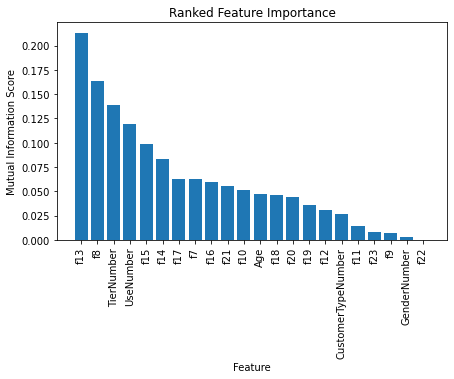

In [ ]:
plt.figure(figsize=(7,4))
plt.bar(sorted_features.tolist(), mi_scores.values)
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Mutual Information Score')
plt.title("Ranked Feature Importance")
plt.show()

In the graph above, we can clearly see that the 5 features with the top 5 MI scores are f13, f8, TierNumber, UseNumber, f15, and f14. These are thus our most informative features. Moreover, we see that the features with the lowest 5 scores and thus least informative features are f11, f23, f9, GenderNumber, and f22.

We will now implement cross validation to see which top $k$ features to preserve in a new XGBoost model, where $k \in \{5, 10, 15, 20\}.$

In [ ]:
from sklearn.model_selection import cross_val_score

num_features_range = [5, 10, 15, 20]

def final_best_features(X_train, y_train, num_features_range, sorted_features, params):
    best_features = None
    best_accuracy = -1
    for i in num_features_range:
        print(f"Keeping {i} best features...")
        features = sorted_features[:i].tolist()
        X_train_reduced = X_train[features]
        print("Training model...")
        model = XGBClassifier(**params)
        print("Testing model...")
        scores = cross_val_score(model, X_train_reduced, y_train, cv=5)
        accuracy = scores.mean()
        print(f"Accuracy for keeping {i} best features: {accuracy}")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_features = features
    return best_features

In [ ]:
final_features = final_best_features(X_train, y_train, num_features_range, sorted_features, params)
X_train_final, X_test_final = X_train[final_features], X_test[final_features]

Keeping 5 best features...
Training model...
Testing model...
Accuracy for keeping 5 best features: 0.9261914792325985
Keeping 10 best features...
Training model...
Testing model...
Accuracy for keeping 10 best features: 0.9417635644724147
Keeping 15 best features...
Training model...
Testing model...
Accuracy for keeping 15 best features: 0.954188468690328
Keeping 20 best features...
Training model...
Testing model...
Accuracy for keeping 20 best features: 0.9635047816824237


It seems that the model that kept the top 20 features performed the best, so we'll use that to make our final evaluation on the test set.

In [ ]:
final_reduced_model = XGBClassifier(**params)

eval_set = [(X_train_final, y_train), (X_test_final, y_test)]

final_reduced_model.fit(X_train_final, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)

y_pred_train = final_reduced_model.predict(X_train_final)
y_pred_test = final_reduced_model.predict(X_test_final)


final_train_accuracy = metrics.accuracy_score(y_train, y_pred_train)
final_test_accuracy = metrics.accuracy_score(y_test, y_pred_test)
results = final_reduced_model.evals_result()

We will now go ahead and plot the log loss and error of our XGBoost model during training:

In [ ]:
def plot_history(model):
    results = model.evals_result()
    num_epochs = len(results['validation_0']['error'])
    x = range(0, num_epochs)

    fig, ax = plt.subplots()
    ax.plot(x, results['validation_0']['logloss'], label='Train')
    ax.plot(x, results['validation_1']['logloss'], label='Test')
    ax.legend()
    plt.ylabel('Loss')
    plt.title('XGBoost Log Loss')
    plt.show()
    # plot classification error
    fig, ax = plt.subplots()
    ax.plot(x, results['validation_0']['error'], label='Train')
    ax.plot(x, results['validation_1']['error'], label='Test')
    ax.legend()
    plt.ylabel('Classification Error')
    plt.title('XGBoost Classification Error')
    plt.show()

Final Train Accuracy:  0.9701070218663381
Final Test Accuracy:  0.9641207268247614


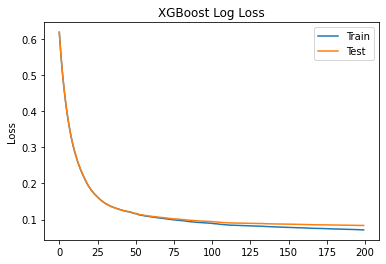

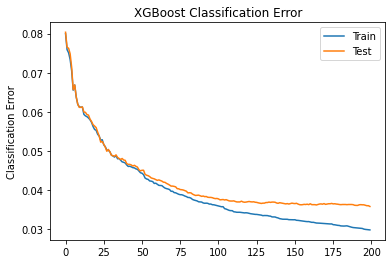

In [ ]:
print("Final Train Accuracy: ",final_train_accuracy)
print("Final Test Accuracy: ", final_test_accuracy)
plot_history(final_reduced_model)

It seems that the model overfits quite a bit, but the discrepancy accounting for the training error and test error is less than 1%, which isn't too bad. Moreover, we see that cross-validation didn't give a model that performed better than the one trained on all of the features. However, it does use less features nonetheless.

We'll go ahead and save this model.

In [ ]:
joblib.dump(final_reduced_model, "final_reduced_model.pkl", compress = 3)

['final_reduced_model.pkl']